In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../src")
import evidence

In [2]:
beta_K = np.load(r"./beta_k.npy")
lls = np.load(r"./loglikelihood_n_k_r.npy")
ll_n_k = lls[..., lls.shape[-1]//2:].transpose(1,0,2).reshape(beta_K.size, -1)

In [3]:
solver = evidence.SolveEvidence(beta_K, -ll_n_k, W=4, n_bins_wham=10**5)

# Halve the spacing of the beta sequence and add more points on the smaller side
new_betas = evidence.expand_betas(beta_K)
new_beta_groups, stat_groups = solver.pred_dist(new_betas)

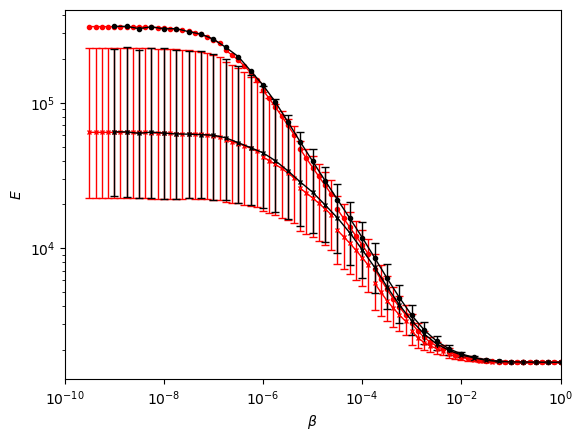

In [4]:
for betas, stats in zip(new_beta_groups, stat_groups):
    plt.plot(betas, stats[-1], "o-", color="r", linewidth=1, markersize=3)
    plt.errorbar(betas, stats[1], yerr=abs(stats[[0,2]]-stats[1]), fmt="x-", color="r", linewidth=1, markersize=3, capsize=3)

plt.plot(solver.beta_K, solver.E_NK.mean(axis=1), "o-", color="k", linewidth=1, markersize=3)
percs = np.percentile(solver.E_NK, [25, 50, 75], axis=1)
plt.errorbar(solver.beta_K, percs[1], yerr=abs(percs[[0,2]]-percs[1]), fmt="x-", color="k", linewidth=1, markersize=3, capsize=3)

plt.xscale("log")
plt.yscale('log')
plt.xlim(evidence.pow_floor(new_betas.min()), 1)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$E$")
plt.show()

In [5]:
log_Z_KB = evidence.calc_evidence_bootstrap_parallel(beta_K, ll_n_k, W=4, n_bins_wham=10**5, n_bootstrap=10)
#log_Z_KB, solvers = evidence.calc_evidence_bootstrap(beta_K, ll_n_k, W=4, n_bins_wham=10**5, n_bootstrap=1)


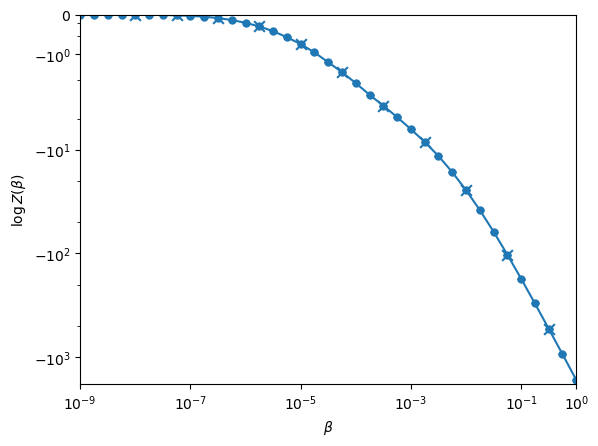

In [7]:
means = log_Z_KB.mean(axis=0)
errs = log_Z_KB.std(axis=0)
plt.errorbar(
    beta_K, means, yerr=errs,
    fmt="o-", capsize=3, markersize=5)
plt.scatter(beta_K[solver.seams_index], means[solver.seams_index], s=60, marker="x") # type: ignore

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\log Z(\beta)$")
plt.yscale("asinh") # type: ignore
plt.xscale("log")
plt.xlim(evidence.pow_floor(beta_K.min()), 1)
plt.ylim(means[beta_K==1]*1.1, 0)
plt.xticks(sorted({x for x in plt.xticks()[0] if evidence.pow_floor(beta_K.min())<=x<=1} | {1}))
plt.yticks([y for y in plt.yticks()[0] if not(0<abs(y)<1)])
plt.show()